# Open-source LLM's as Agents with `HuggingFaceChatWrapper`


Open source LLMs are becoming viable general purpose agents. The goal of this notebook is to demonstrate how to make use of open-source LLMs as chat models using [Hugging Face Inference Endpoints](https://huggingface.co/docs/inference-endpoints/index) with [LangChain's `HuggingFaceChatWrapper`]() to enable their usage and experimentation with agent-based workflows.

In particular, we will:
1. Utilize the [HuggingFaceEndpoint](https://github.com/langchain-ai/langchain/blob/master/libs/langchain/langchain/llms/huggingface_endpoint.py) (or [HuggingFaceTextGenInference](https://github.com/langchain-ai/langchain/blob/master/libs/langchain/langchain/llms/huggingface_text_gen_inference.py) or [HuggingFaceHub](https://github.com/langchain-ai/langchain/blob/master/libs/langchain/langchain/llms/huggingface_hub.py)) integration to call a [HF Inference Endpoint](https://huggingface.co/inference-endpoints) that's serving an LLM via [Text Generation Inference (TGI)](https://huggingface.co/docs/text-generation-inference/index)
2. Utilize the `HuggingFaceChatWrapper` class that interfaces between LangChain's [Chat Messages](https://python.langchain.com/docs/modules/model_io/chat/#messages) and the hosted LLM by leveraging [Hugging Face's Chat Templates](https://huggingface.co/docs/transformers/chat_templating) to power a `ChatAgent` pipeline.
4. Demonstrate how to use an open-source LLM in a zero-shot ReAct Agent workflow, along with an open-source [Prometheus](https://huggingface.co/papers/2310.08491) model to perform "LLM as a Judge"-style evaluations on that Agent's ouputs.
5. Understand how several different open-source LLM's perform as general purpose agents by running an asynchronous evaluation pipeline using Prometheus as the judge. 



> Note: To run this notebook, you'll need to have:
> - an LLM deployed via a Hugging Face Inference Endpoint (the LLM must have a `chat_template` defined in its `tokenizer_config.json`)
> - A Hugging Face Token with access to the deployed endpoint saved as an environment variable: `HUGGINGFACEHUB_API_TOKEN`
> - A SerpAPI key saved as an environment variable: `SERPAPI_API_KEY`


## Setup

In [35]:
!pip install -q transformers langchain text-generation python-dotenv jinja2 google-search-results langchainhub numexpr datasets tqdm openai sentencepiece protobuf matplotlib


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# ruff: noqa: E402

from dotenv import load_dotenv

load_dotenv(override=True)

True

## 1. Instantiate an LLM

You'll need to have a running Inference Endpoint available.

#### `HuggingFaceTextGenInference`

In [ ]:
import os
from langchain.llms import HuggingFaceTextGenInference

ENDPOINT_URL = "<YOUR_ENDPOINT_URL_HERE>"
HF_TOKEN = os.getenv("HUGGINGFACEHUB_API_TOKEN")

llm = HuggingFaceTextGenInference(
    inference_server_url=ENDPOINT_URL,
    max_new_tokens=512,
    top_k=50,
    temperature=0.1,
    repetition_penalty=1.03,
    server_kwargs={
        "headers": {
            "Authorization": f"Bearer {HF_TOKEN}",
            "Content-Type": "application/json",
        }
    },
)

#### `HuggingFaceHub`

In [ ]:
from langchain.llms import HuggingFaceHub

llm = HuggingFaceHub(
    repo_id="meta-llama/Llama-2-7b-chat-hf",
    task="text-generation",
    model_kwargs={
        "max_new_tokens": 512,
        "top_k": 50,
        "temperature": 0.1,
        "repetition_penalty": 1.03,
    },
)

#### `HuggingFaceEndpoint`

In [5]:
from langchain.llms import HuggingFaceEndpoint

endpoint_url = "https://b64oqapulf4lv8w1.us-east-1.aws.endpoints.huggingface.cloud"  # zephyr-7b-beta
llm = HuggingFaceEndpoint(
    endpoint_url=endpoint_url,
    task="text-generation",
    model_kwargs={
        "max_new_tokens": 512,
        "top_k": 50,
        "temperature": 0.1,
        "repetition_penalty": 1.03,
    },
)

## 2. Create a wrapper for `BaseChatModel` to apply chat templates

In [6]:
from langchain.schema import (
    HumanMessage,
    SystemMessage,
)

from hugging_face_chat_wrapper import HuggingFaceChatWrapper

Instantiate the model and some messages to pass.

In [ ]:
messages = [
    SystemMessage(content="You're a helpful assistant"),
    HumanMessage(
        content="What happens when an unstoppable force meets an immovable object?"
    ),
]

chat_model = HuggingFaceChatWrapper(llm=llm)

Inspect which model and corresponding chat template is being used.

In [8]:
chat_model.model_id

'HuggingFaceH4/zephyr-7b-beta'

Inspect how the chat messages are formatted for the LLM call.

In [9]:
chat_model._to_chat_prompt(messages)

"<|system|>\nYou're a helpful assistant</s>\n<|user|>\nWhat happens when an unstoppable force meets an immovable object?</s>\n<|assistant|>\n"

Call the model.

In [11]:
res = chat_model.invoke(messages)
print(res.content)

According to the popular idiom, when an unstoppable force meets an immovable object, there is a paradoxical situation where both forces seem to contradict each other's nature. The force that is absolutely unstoppable should overcome the object that is completely immovable, but in this scenario, both forces are presented as absolute extremes, making it impossible for either one to give way. This paradoxical situation creates a thought-provoking conundrum that challenges our understanding of cause and effect. However, in reality, such a scenario is hypothetical and cannot exist in the physical world as both concepts are metaphors used to describe extreme situations. In physics, the concept of an unstoppable force or an immovable object does not exist, and the laws of physics govern how objects interact with each other.


## 3. Take it for a spin!

Here we'll test out `Zephyr-7B-beta` as a zero-shot ReAct Agent. The example below is taken from [here](https://python.langchain.com/docs/modules/agents/agent_types/react#using-chat-models).

In [14]:
from langchain.agents import load_tools
from langchain.agents.format_scratchpad import format_log_to_str
from langchain.tools.render import render_text_description
from langchain.agents import AgentExecutor
from langchain.agents.output_parsers import (
    ReActJsonSingleInputOutputParser,
)
from prompts import SYSTEM_PROMPT, HUMAN_PROMPT
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)

Configure the agent with a `react-json` style prompt and access to a search engine and calculator.

In [15]:
# setup tools
tools = load_tools(["serpapi", "llm-math"], llm=llm)

prompt = ChatPromptTemplate.from_messages(
    [
        SystemMessagePromptTemplate.from_template(SYSTEM_PROMPT),
        HumanMessagePromptTemplate.from_template(HUMAN_PROMPT),
    ]
)
prompt = prompt.partial(
    tools=render_text_description(tools),
    tool_names=", ".join([t.name for t in tools]),
)

# define the agent
chat_model_with_stop = chat_model.bind(stop=["\nObservation"])
agent = (
    {
        "input": lambda x: x["input"],
        "agent_scratchpad": lambda x: format_log_to_str(x["intermediate_steps"]),
    }
    | prompt
    | chat_model_with_stop
    | ReActJsonSingleInputOutputParser()
)

# instantiate AgentExecutor
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True,
    return_intermediate_steps=True,
    handle_parsing_errors=True,
    max_iterations=5,
)

In [18]:
example = {
    "input": "Who is Leo DiCaprio's girlfriend? What is her current age raised to the 0.43 power?"
}

out = agent_executor.invoke(example)



> Entering new AgentExecutor chain...
Question: Who is Leo DiCaprio's girlfriend? What is her current age raised to the 0.43 power?

Thought: I need to find out who Leo DiCaprio's current girlfriend is and then calculate her age raised to the power of 0.43.

Action:
```
{
  "action": "Search",
  "action_input": "leo dicaprio girlfriend"
}
```Vittoria CerettiNow I need to find out the current age of Leo DiCaprio's girlfriend, Vittoria Ceretti.

Action:
```
{
  "action": "Search",
  "action_input": "vittoria ceretti age"
}
```25 yearsFinal Answer: The age of Leo DiCaprio's girlfriend, Vittoria Ceretti, raised to the power of 0.43 is approximately 11.69.

> Finished chain.


In [19]:
out

{'input': "Who is Leo DiCaprio's girlfriend? What is her current age raised to the 0.43 power?",
 'output': "The age of Leo DiCaprio's girlfriend, Vittoria Ceretti, raised to the power of 0.43 is approximately 11.69.",
 'intermediate_steps': [(AgentAction(tool='Search', tool_input='leo dicaprio girlfriend', log='Question: Who is Leo DiCaprio\'s girlfriend? What is her current age raised to the 0.43 power?\n\nThought: I need to find out who Leo DiCaprio\'s current girlfriend is and then calculate her age raised to the power of 0.43.\n\nAction:\n```\n{\n  "action": "Search",\n  "action_input": "leo dicaprio girlfriend"\n}\n```'),
   'Vittoria Ceretti'),
  (AgentAction(tool='Search', tool_input='vittoria ceretti age', log='Now I need to find out the current age of Leo DiCaprio\'s girlfriend, Vittoria Ceretti.\n\nAction:\n```\n{\n  "action": "Search",\n  "action_input": "vittoria ceretti age"\n}\n```'),
   '25 years')]}

## Evaluate the agent's ouput by criteria: correctness

### Evaluate using Prometheus

In [ ]:
from hugging_face_chat_wrapper import HuggingFaceChatWrapper

# create endpoint and chat model
endpoint_url = "https://hg1fvppohh20ufdf.us-east-1.aws.endpoints.huggingface.cloud"
eval_llm = HuggingFaceEndpoint(
    endpoint_url=endpoint_url,
    task="text-generation",
    model_kwargs={
        "max_new_tokens": 512,
        "top_k": 50,
        "temperature": 0.1,
        "repetition_penalty": 1.03,
    },
)

eval_chat_model = HuggingFaceChatWrapper(llm=eval_llm)

In [21]:
eval_chat_model.model_id, eval_chat_model._to_chat_prompt(messages)


No chat template is defined for this tokenizer - using the default template for the LlamaTokenizerFast class. If the default is not appropriate for your model, please set `tokenizer.chat_template` to an appropriate template. See https://huggingface.co/docs/transformers/main/chat_templating for more information.



('TheBloke/prometheus-13B-v1.0-GPTQ',
 "<s>[INST] <<SYS>>\nYou're a helpful assistant\n<</SYS>>\n\nWhat happens when an unstoppable force meets an immovable object? [/INST]")

In [24]:
from prompts import PROMETHEUS_PROMPT

prometheus_prompt_template = ChatPromptTemplate.from_messages(
    [
        SystemMessage(content="You are a fair evaluator language model."),
        HumanMessagePromptTemplate.from_template(PROMETHEUS_PROMPT),
    ]
)

correctness_criteria = {
    "criteria_description": "Is the response correct, accurate, and factual based on the reference answer?",
    "score1_description": "The response is completely incorrect, inaccurate, and/or not factual.",
    "score2_description": "The response is mostly incorrect, inaccurate, and/or not factual.",
    "score3_description": "The response is somewhat correct, accurate, and/or factual.",
    "score4_description": "The response is mostly correct, accurate, and factual.",
    "score5_description": "The response is completely correct, accurate, and factual.",
}

correctness_prompt_template = prometheus_prompt_template.partial(
    criteria_description=correctness_criteria["criteria_description"],
    score1_description=correctness_criteria["score1_description"],
    score2_description=correctness_criteria["score2_description"],
    score3_description=correctness_criteria["score3_description"],
    score4_description=correctness_criteria["score4_description"],
    score5_description=correctness_criteria["score5_description"],
)

In [25]:
eval_prompt = correctness_prompt_template.format_messages(
    instruction=example["input"],
    response=out["output"],
    reference_answer="Vittoria Ceretti who is 25 years old. When age of 25 is raised to power of 0.43, we get 3.99",
)

In [26]:
print(eval_prompt[1].content)

###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a reference answer that gets a score of 5, and a score rubric representing a evaluation criteria are given.
1. Write a detailed feedback that assess the quality of the response strictly based on the given score rubric, not evaluating in general.
2. After writing a feedback, write a score that is an integer between 1 and 5. You should refer to the score rubric.
3. The output format should look as follows: "Feedback: (write a feedback for criteria) [RESULT] (an integer number between 1 and 5)"
4. Please do not generate any other opening, closing, and explanations.

###The instruction to evaluate:
Who is Leo DiCaprio's girlfriend? What is her current age raised to the 0.43 power?

###Response to evaluate:
The age of Leo DiCaprio's girlfriend, Vittoria Ceretti, raised to the power of 0.43 is approximately 11.69.

###Reference Answer (Score 5):
Vittoria Ceretti who is 25 years old. When age of 25

In [27]:
eval_out = eval_chat_model.invoke(eval_prompt)
print(eval_out)

content='  The response is mostly correct, accurate, and factual. It correctly identifies the girlfriend of Leonardo DiCaprio as Vittoria Ceretti and provides an approximate value for the result of raising her age to the power of 0.43. However, the response does not provide the exact value of 25 years old, which is the correct answer according to the reference response. So the overall score is 4. [RESULT] 4'


## Evaluation Experiment 

- Find a group of test questions that use a certain set of tools to solve (HotpotQA)
- Run several different models as agent to solve the test questions (os and proprietary)
- Use GPT4 as a judge
- Use OS models as a judge
- Report correlations

In [33]:
from datasets import load_dataset

dataset = load_dataset("hotpot_qa", "distractor")

# let's sample a few examples from each level (of difficulty) and type (comparion or bridge)
dataset.set_format("pandas")
dataset_df = dataset["train"][:]
sample_indicies = (
    dataset_df.groupby(["level", "type"]).sample(2, random_state=10).index.values
)
dataset.reset_format()
dataset = dataset["train"].select(sample_indicies)

In [34]:
dataset

Dataset({
    features: ['id', 'question', 'answer', 'type', 'level', 'supporting_facts', 'context'],
    num_rows: 12
})

In [35]:
from evaluation import run_full_eval, build_evaluator

In [ ]:
agent_endpoints = [
    "https://b64oqapulf4lv8w1.us-east-1.aws.endpoints.huggingface.cloud",  # zephyr-7b-beta
    "https://i45e7q2do4r8mw5k.us-east-1.aws.endpoints.huggingface.cloud",  # notus-7b
    "https://jsfpmcv7wgv9acvh.us-east-1.aws.endpoints.huggingface.cloud",  # open-hermes-2.5-7b
]

eval_endpoint = "https://hg1fvppohh20ufdf.us-east-1.aws.endpoints.huggingface.cloud"

# get eval model and prompt
eval_chat_model, correctness_prompt_template = build_evaluator(
    hf_endpoint_url=eval_endpoint
)

# run eval
result_df = await run_full_eval(
    dataset=dataset,
    agent_model_endpoints=agent_endpoints,
    evaluator=eval_chat_model,
    eval_prompt_template=correctness_prompt_template,
)

In [37]:
result_df.sort_values("start_time")

,agent_model_id,evaluator_model_id,question,gt_answer,prediction,intermediate_steps,eval_score,eval_feedback,parsing_error,iteration_limit_exceeded,agent_error,start_time,end_time,id,type,level
0,huggingfaceh4/zephyr-7b-beta-style,TheBloke/prometheus-13B-v1.0-GPTQ,Who was born in 1936 and committed the Massacr...,Harry Roberts,The true perpetrator of the Massacre of Braybr...,[(tool='Search' tool_input='who was born in 19...,1,"The response is incorrect, inaccurate, and not...",False,False,None,2023-12-04 20:43:41,2023-12-04 20:44:10,5a7e1ada5542995ed0d16697,bridge,easy
12,argilla/notus-7b-v1-style,TheBloke/prometheus-13B-v1.0-GPTQ,Who was born in 1936 and committed the Massacr...,Harry Roberts,Agent stopped due to iteration limit or time l...,[(tool='Search' tool_input='Hoddle Street mass...,1,The response does not provide any information ...,False,True,None,2023-12-04 20:43:41,2023-12-04 20:45:18,5a7e1ada5542995ed0d16697,bridge,easy
24,teknium/openhermes-2.5-mistral-7b-style,TheBloke/prometheus-13B-v1.0-GPTQ,Who was born in 1936 and committed the Massacr...,Harry Roberts,Harry Maurice Roberts,[(tool='Search' tool_input='1936 birth year Ma...,1,"The response ""Harry Maurice Roberts"" is not co...",False,False,None,2023-12-04 20:43:41,2023-12-04 20:43:55,5a7e1ada5542995ed0d16697,bridge,easy
25,teknium/openhermes-2.5-mistral-7b-style,TheBloke/prometheus-13B-v1.0-GPTQ,"David Pear was a NFL football player, that won...",Oakland Raiders,Oakland Raiders,[(tool='Search' tool_input='David Pear Super B...,5,"The response is completely correct, accurate, ...",False,False,None,2023-12-04 20:43:55,2023-12-04 20:44:03,5a730c1f5542991f29ee2cfc,bridge,easy
26,teknium/openhermes-2.5-mistral-7b-style,TheBloke/prometheus-13B-v1.0-GPTQ,Is the Outpost Island Mine and Jolly Jack's Lo...,yes,"Based on the search results, it appears that t...","[(tool='Search' tool_input=""Outpost Island Min...",4,"The response is mostly correct, accurate, and ...",False,False,None,2023-12-04 20:44:03,2023-12-04 20:44:26,5ac1ae0e55429963665198e5,comparison,easy
1,huggingfaceh4/zephyr-7b-beta-style,TheBloke/prometheus-13B-v1.0-GPTQ,"David Pear was a NFL football player, that won...",Oakland Raiders,Dave Pear won Super Bowl XV playing for the Oa...,[(tool='Search' tool_input='David Pear super b...,5,"The response is completely correct, accurate, ...",False,False,None,2023-12-04 20:44:10,2023-12-04 20:44:21,5a730c1f5542991f29ee2cfc,bridge,easy
2,huggingfaceh4/zephyr-7b-beta-style,TheBloke/prometheus-13B-v1.0-GPTQ,Is the Outpost Island Mine and Jolly Jack's Lo...,yes,"Yes, both the Outpost Island Mine and Jolly Ja...",[(tool='Search' tool_input='define outpost isl...,5,"The response is completely correct, accurate, ...",False,False,None,2023-12-04 20:44:21,2023-12-04 20:44:36,5ac1ae0e55429963665198e5,comparison,easy
27,teknium/openhermes-2.5-mistral-7b-style,TheBloke/prometheus-13B-v1.0-GPTQ,What were both David Vincent and Lee Min-woo in?,band,Both David Vincent and Lee Min-woo are profess...,[(tool='Search' tool_input='David Vincent and ...,1,"The response is incorrect, inaccurate, and not...",False,False,None,2023-12-04 20:44:26,2023-12-04 20:44:42,5ab8f1c255429934fafe6e1f,comparison,easy
3,huggingfaceh4/zephyr-7b-beta-style,TheBloke/prometheus-13B-v1.0-GPTQ,What were both David Vincent and Lee Min-woo in?,band,Agent stopped due to iteration limit or time l...,[(tool='Search' tool_input='David Vincent and ...,1,The response does not provide any information ...,False,True,None,2023-12-04 20:44:36,2023-12-04 20:46:13,5ab8f1c255429934fafe6e1f,comparison,easy
28,teknium/openhermes-2.5-mistral-7b-style,TheBloke/prometheus-13B-v1.0-GPTQ,Where are the headquarters of the league the D...,"Elmhurst, Illinois","The headquarters of the Summit League, the lea...",[(tool='Search' tool_input='Denver Pioneers le...,3,"The response is mostly correct, accurate, and ...",False,False,None,2023-12-04 20:44:42,2023-12-04 20:45:04,5ab291e3554299545a2cf98c,bridge,hard


In [38]:
result_df.eval_score = result_df.eval_score.astype(int)
result_df.groupby("agent_model_id").agg(
    {"eval_score": "mean", "parsing_error": "sum", "iteration_limit_exceeded": "sum"}
)

,eval_score,parsing_error,iteration_limit_exceeded
agent_model_id,,,
argilla/notus-7b-v1-style,2.333333,0,7
huggingfaceh4/zephyr-7b-beta-style,2.666667,4,4
teknium/openhermes-2.5-mistral-7b-style,3.333333,0,0


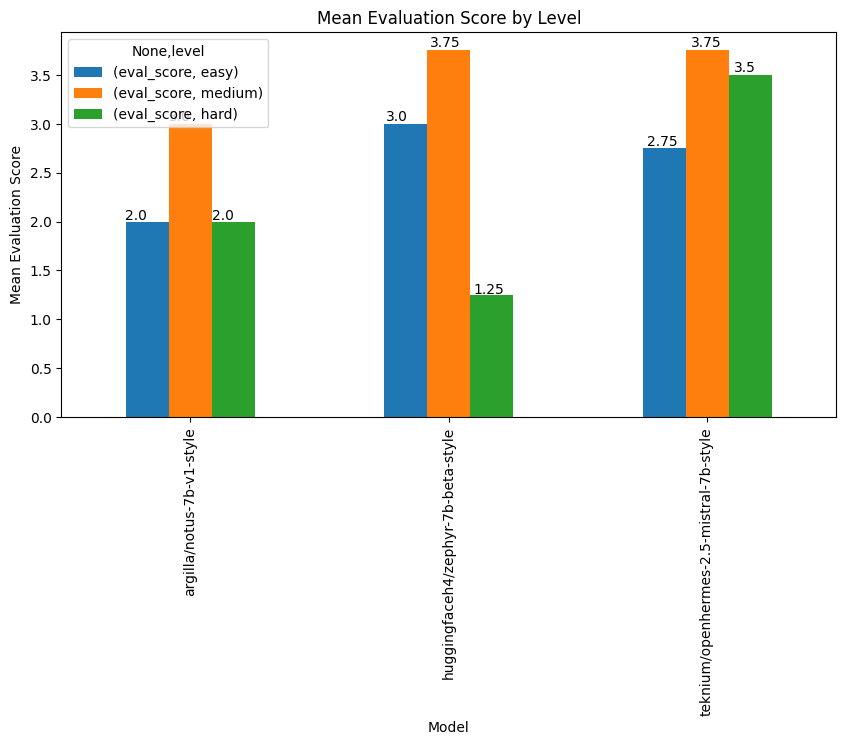

In [39]:
agg_df = (
    result_df.groupby(["agent_model_id", "level"])
    .agg({"eval_score": "mean"})
    .unstack("level")
)

ax = agg_df[
    [("eval_score", "easy"), ("eval_score", "medium"), ("eval_score", "hard")]
].plot.bar(
    figsize=(10, 5),
    title="Mean Evaluation Score by Level",
    xlabel="Model",
    ylabel="Mean Evaluation Score",
)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01, p.get_height() * 1.01))

#### visualizations to make
- avg model score by question difficulty
- count of parsing errors and iteration limit errors

## To-do:
- Generalize evaluation code
- Make evals fully async
- Select 3-5 models to evaluate on
- Run eval
- Write blog post
- Get LangChain PR merged

## Notes

- One of the main challenges with open LLMs is ensuring they adhere to the proper markdown JSON output!
- Another is when they serve as the evaluator, they struggle to handle the default "labeled_criteria" prompt and end up hallucinating. Needs to be modified / simplified.
- I also found that GPT4 actually did pretty poor at judging correctness given the default LangChain prompt!